In [ ]:
import torch
import clip
from PIL import Image
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from io import BytesIO
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from tqdm import tqdm
import random
from torch.nn.functional import cosine_similarity
from sklearn.metrics.pairwise import cosine_similarity as cosine_similarity_sklearn
from skimage.metrics import peak_signal_noise_ratio as compare_psnr
from skimage.metrics import structural_similarity as compare_ssim
import torchvision.utils as vutils
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

In [3]:
data_transforms = transforms.Compose([
    transforms.Resize(512),
    transforms.CenterCrop(512),
    preprocess
])

In [4]:
dataset = datasets.ImageFolder('../../data/midjourney/train', transform=data_transforms)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=False)

In [5]:
def add_gaussian_noise(image, mean=0.0, std=0.1):
    noise = torch.randn(image.size(), device=image.device) * std + mean
    noisy_image = image + noise
    noisy_image = torch.clamp(noisy_image, 0.0, 1.0)
    return noisy_image

def apply_jpeg_compression(image, quality=90):
    image = torch.clamp(image, 0, 1).cpu()
    image_pil = transforms.ToPILImage()(image)

    buffer = BytesIO()
    image_pil.save(buffer, format='JPEG', quality=quality)
    buffer.seek(0)

    compressed_image_pil = Image.open(buffer)
    compressed_image_tensor = transforms.ToTensor()(compressed_image_pil)
    return compressed_image_tensor.to(image.device)


In [6]:
def compute_psnr(image1, image2):
    image1_np = np.array(image1).astype(np.float32) / 255.0
    image2_np = np.array(image2).astype(np.float32) / 255.0
    psnr = compare_psnr(image1_np, image2_np, data_range=1.0)
    return psnr

def compute_ssim(image1, image2):
    image1_np = np.array(image1).astype(np.float32) / 255.0
    image2_np = np.array(image2).astype(np.float32) / 255.0
    if image1_np.ndim == 3:
        image1_gray = np.mean(image1_np, axis=2) # convert to grayscale
    else:
        image1_gray = image1_np
    if image2_np.ndim == 3:
        image2_gray = np.mean(image2_np, axis=2)
    else:
        image2_gray = image2_np
    ssim = compare_ssim(image1_gray, image2_gray, data_range=1.0)
    return ssim

In [7]:
original_embeddings = []
gaussian_embeddings = []
jpeg_embeddings = []
psnr_gaussian, ssim_gaussian = [], []
psnr_jpeg, ssim_jpeg = [], []

In [8]:
with torch.no_grad():
    for images, _ in tqdm(dataloader, desc="Processing Batches"):
        images = images.to(device)
        
        # original embeddings
        original_features = model.encode_image(images).float()
        original_features /= original_features.norm(dim=-1, keepdim=True)
        original_embeddings.append(original_features.cpu())

        # gaussian noise embeddings
        noisy_images = add_gaussian_noise(images)
        noisy_features = model.encode_image(noisy_images).float()
        noisy_features /= noisy_features.norm(dim=-1, keepdim=True)
        gaussian_embeddings.append(noisy_features.cpu())

        images_pil = [transforms.ToPILImage()(torch.clamp(img, 0, 1).cpu() * 255) for img in images]

        noisy_images_pil = [transforms.ToPILImage()(torch.clamp(img, 0, 1).cpu() * 255) for img in noisy_images]
        for orig, noisy in zip(images_pil, noisy_images_pil):
            psnr_gaussian.append(compute_psnr(orig, noisy))
            ssim_gaussian.append(compute_ssim(orig, noisy))

        # jpeg compression embeddings and similarity
        compressed_images = torch.stack([apply_jpeg_compression(img) for img in images.cpu()])
        compressed_images = compressed_images.to(device)  # Ensure compressed images are back on device
        compressed_features = model.encode_image(compressed_images).float()
        compressed_features /= compressed_features.norm(dim=-1, keepdim=True)
        jpeg_embeddings.append(compressed_features.cpu())

        compressed_images_pil = [transforms.ToPILImage()(torch.clamp(img, 0, 1).cpu() * 255) for img in compressed_images]
        for orig, compressed in zip(images_pil, compressed_images_pil):
            psnr_jpeg.append(compute_psnr(orig, compressed))
            ssim_jpeg.append(compute_ssim(orig, compressed))

Processing Batches: 100%|██████████| 78/78 [05:30<00:00,  4.24s/it]


In [9]:
original_embeddings = torch.cat(original_embeddings)
gaussian_embeddings = torch.cat(gaussian_embeddings)
jpeg_embeddings = torch.cat(jpeg_embeddings)

In [10]:
# converting to float32 for cosine similarity calculation
original_embeddings = original_embeddings.to(dtype=torch.float32)
gaussian_embeddings = gaussian_embeddings.to(dtype=torch.float32)
jpeg_embeddings = jpeg_embeddings.to(dtype=torch.float32)

cos_sim_gaussian = cosine_similarity(original_embeddings, gaussian_embeddings, dim=1)
cos_sim_jpeg = cosine_similarity(original_embeddings, jpeg_embeddings, dim=1)

# compute cosine similarities between different images
num_images = original_embeddings.shape[0]
inter_image_similarities = []

for _ in range(num_images):
    idx1, idx2 = random.sample(range(num_images), 2)
    emb1 = original_embeddings[idx1]
    emb2 = original_embeddings[idx2]
    sim = cosine_similarity(emb1.unsqueeze(0), emb2.unsqueeze(0)).item()
    inter_image_similarities.append(sim)

inter_image_similarities = torch.tensor(inter_image_similarities)

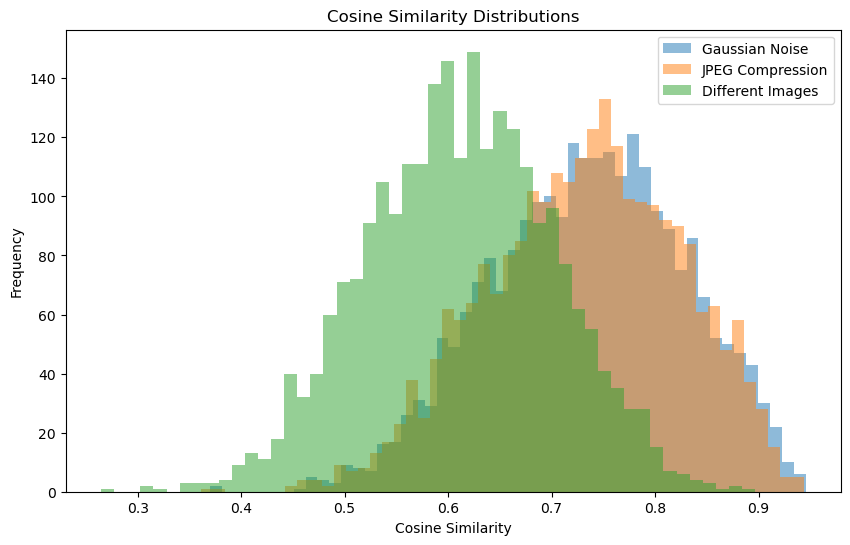

In [11]:
cos_sim_gaussian = cos_sim_gaussian.numpy()
cos_sim_jpeg = cos_sim_jpeg.numpy()
inter_image_similarities = inter_image_similarities.numpy()

plt.figure(figsize=(10, 6))
plt.hist(cos_sim_gaussian, bins=50, alpha=0.5, label='Gaussian Noise')
plt.hist(cos_sim_jpeg, bins=50, alpha=0.5, label='JPEG Compression')
plt.hist(inter_image_similarities, bins=50, alpha=0.5, label='Different Images')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.legend()
plt.title('Cosine Similarity Distributions')
plt.show()

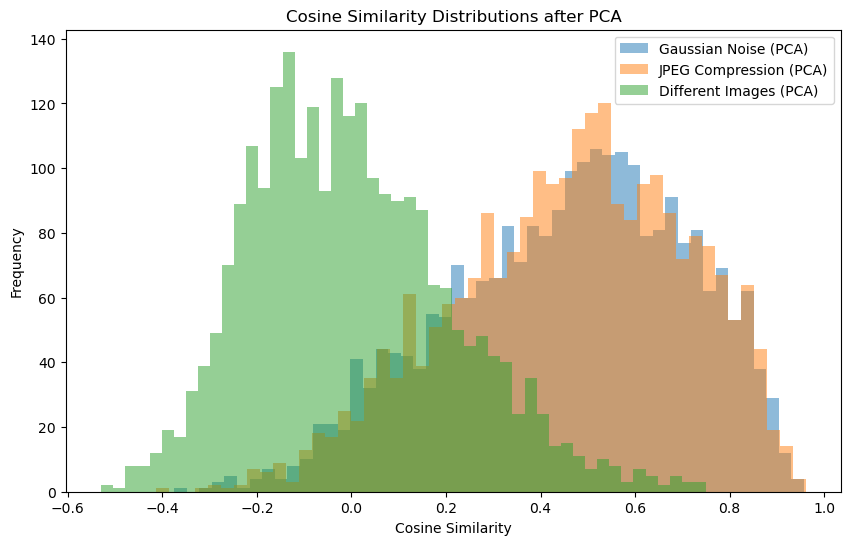

In [12]:
original_embeddings_np = original_embeddings.numpy()
gaussian_embeddings_np = gaussian_embeddings.numpy()
jpeg_embeddings_np = jpeg_embeddings.numpy()

pca = PCA(n_components=50)
pca.fit(original_embeddings_np)

original_embeddings_pca = pca.transform(original_embeddings_np)
gaussian_embeddings_pca = pca.transform(gaussian_embeddings_np)
jpeg_embeddings_pca = pca.transform(jpeg_embeddings_np)

cos_sim_gaussian_pca = np.diag(cosine_similarity_sklearn(original_embeddings_pca, gaussian_embeddings_pca))
cos_sim_jpeg_pca = np.diag(cosine_similarity_sklearn(original_embeddings_pca, jpeg_embeddings_pca))

inter_image_similarities_pca = []

for _ in range(num_images):
    idx1, idx2 = random.sample(range(num_images), 2)
    emb1 = original_embeddings_pca[idx1].reshape(1, -1)
    emb2 = original_embeddings_pca[idx2].reshape(1, -1)
    sim = cosine_similarity_sklearn(emb1, emb2)[0][0]
    inter_image_similarities_pca.append(sim)

inter_image_similarities_pca = np.array(inter_image_similarities_pca)

plt.figure(figsize=(10, 6))
plt.hist(cos_sim_gaussian_pca, bins=50, alpha=0.5, label='Gaussian Noise (PCA)')
plt.hist(cos_sim_jpeg_pca, bins=50, alpha=0.5, label='JPEG Compression (PCA)')
plt.hist(inter_image_similarities_pca, bins=50, alpha=0.5, label='Different Images (PCA)')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.legend()
plt.title('Cosine Similarity Distributions after PCA')
plt.show()

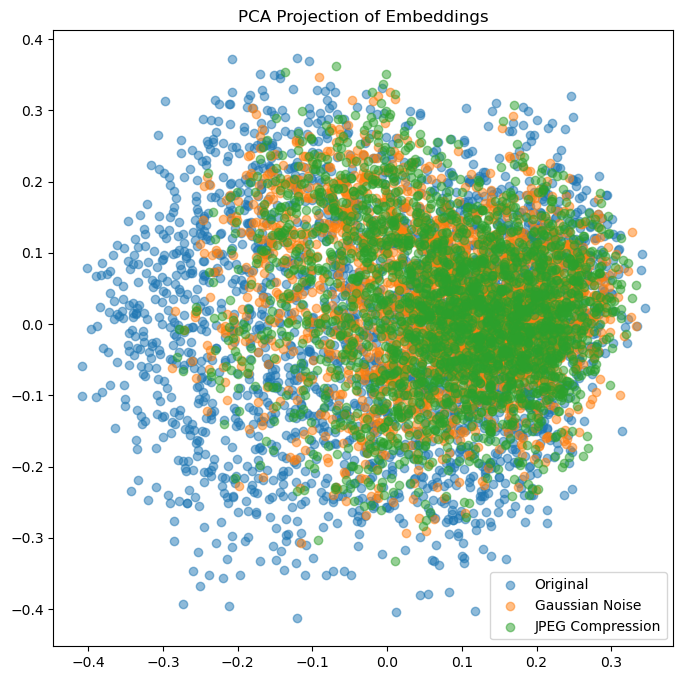

In [13]:
pca = PCA(n_components=2)
original_pca = pca.fit_transform(original_embeddings)
gaussian_pca = pca.transform(gaussian_embeddings)
jpeg_pca = pca.transform(jpeg_embeddings)

tsne = TSNE(n_components=2, perplexity=30)
original_tsne = tsne.fit_transform(original_embeddings)

plt.figure(figsize=(8, 8))
plt.scatter(original_pca[:, 0], original_pca[:, 1], alpha=0.5, label='Original')
plt.scatter(gaussian_pca[:, 0], gaussian_pca[:, 1], alpha=0.5, label='Gaussian Noise')
plt.scatter(jpeg_pca[:, 0], jpeg_pca[:, 1], alpha=0.5, label='JPEG Compression')
plt.legend()
plt.title('PCA Projection of Embeddings')
plt.show()

In [14]:
psnr_different = []
ssim_different = []

num_pairs = 1000
image_indices = list(range(len(dataset)))

for _ in tqdm(range(num_pairs)):
    idx1, idx2 = random.sample(image_indices, 2)
    image1, _ = dataset[idx1]
    image2, _ = dataset[idx2]

    image1_pil = transforms.ToPILImage()(image1.cpu())
    image2_pil = transforms.ToPILImage()(image2.cpu())

    psnr_value = compute_psnr(image1_pil, image2_pil)
    ssim_value = compute_ssim(image1_pil, image2_pil)
    psnr_different.append(psnr_value)
    ssim_different.append(ssim_value)


100%|██████████| 1000/1000 [01:42<00:00,  9.74it/s]


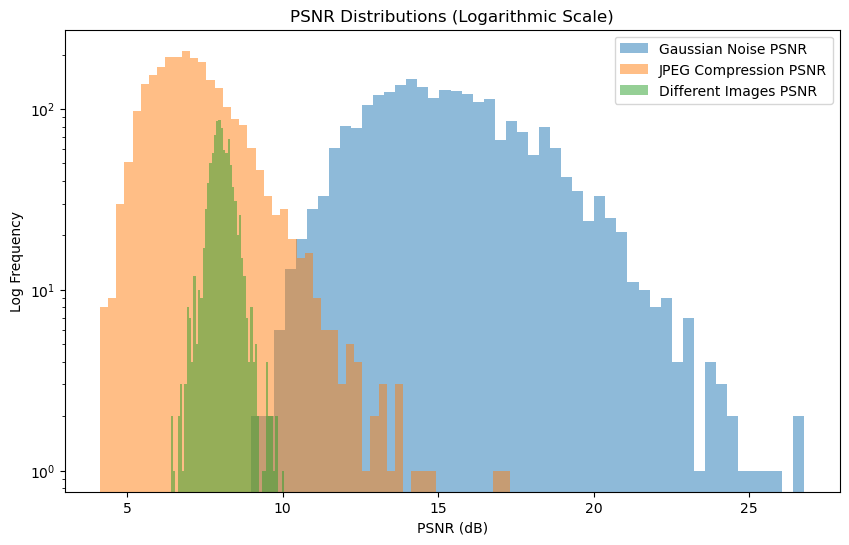

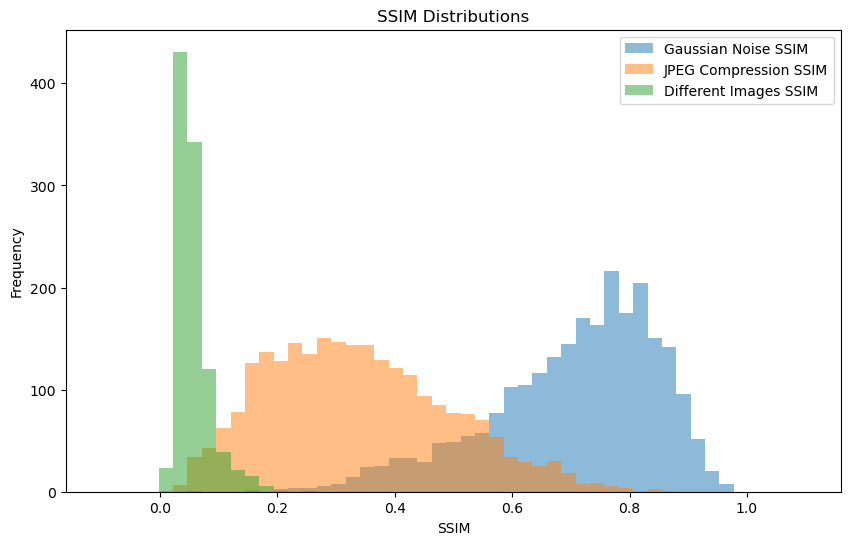

In [15]:
plt.figure(figsize=(10, 6))
plt.hist(psnr_gaussian, bins=50, alpha=0.5, label='Gaussian Noise PSNR', log=True)
plt.hist(psnr_jpeg, bins=50, alpha=0.5, label='JPEG Compression PSNR', log=True)
plt.hist(psnr_different, bins=50, alpha=0.5, label='Different Images PSNR', log=True)
plt.xlabel('PSNR (dB)')
plt.ylabel('Log Frequency')
plt.legend()
plt.title('PSNR Distributions (Logarithmic Scale)')
plt.show()

plt.figure(figsize=(10, 6))
plt.hist(ssim_gaussian, bins=np.linspace(-0.1, 1.1, 50), alpha=0.5, label='Gaussian Noise SSIM')
plt.hist(ssim_jpeg, bins=np.linspace(-0.1, 1.1, 50), alpha=0.5, label='JPEG Compression SSIM')
plt.hist(ssim_different, bins=np.linspace(-0.1, 1.1, 50), alpha=0.5, label='Different Images SSIM')
plt.xlabel('SSIM')
plt.ylabel('Frequency')
plt.legend()
plt.title('SSIM Distributions')
plt.show()

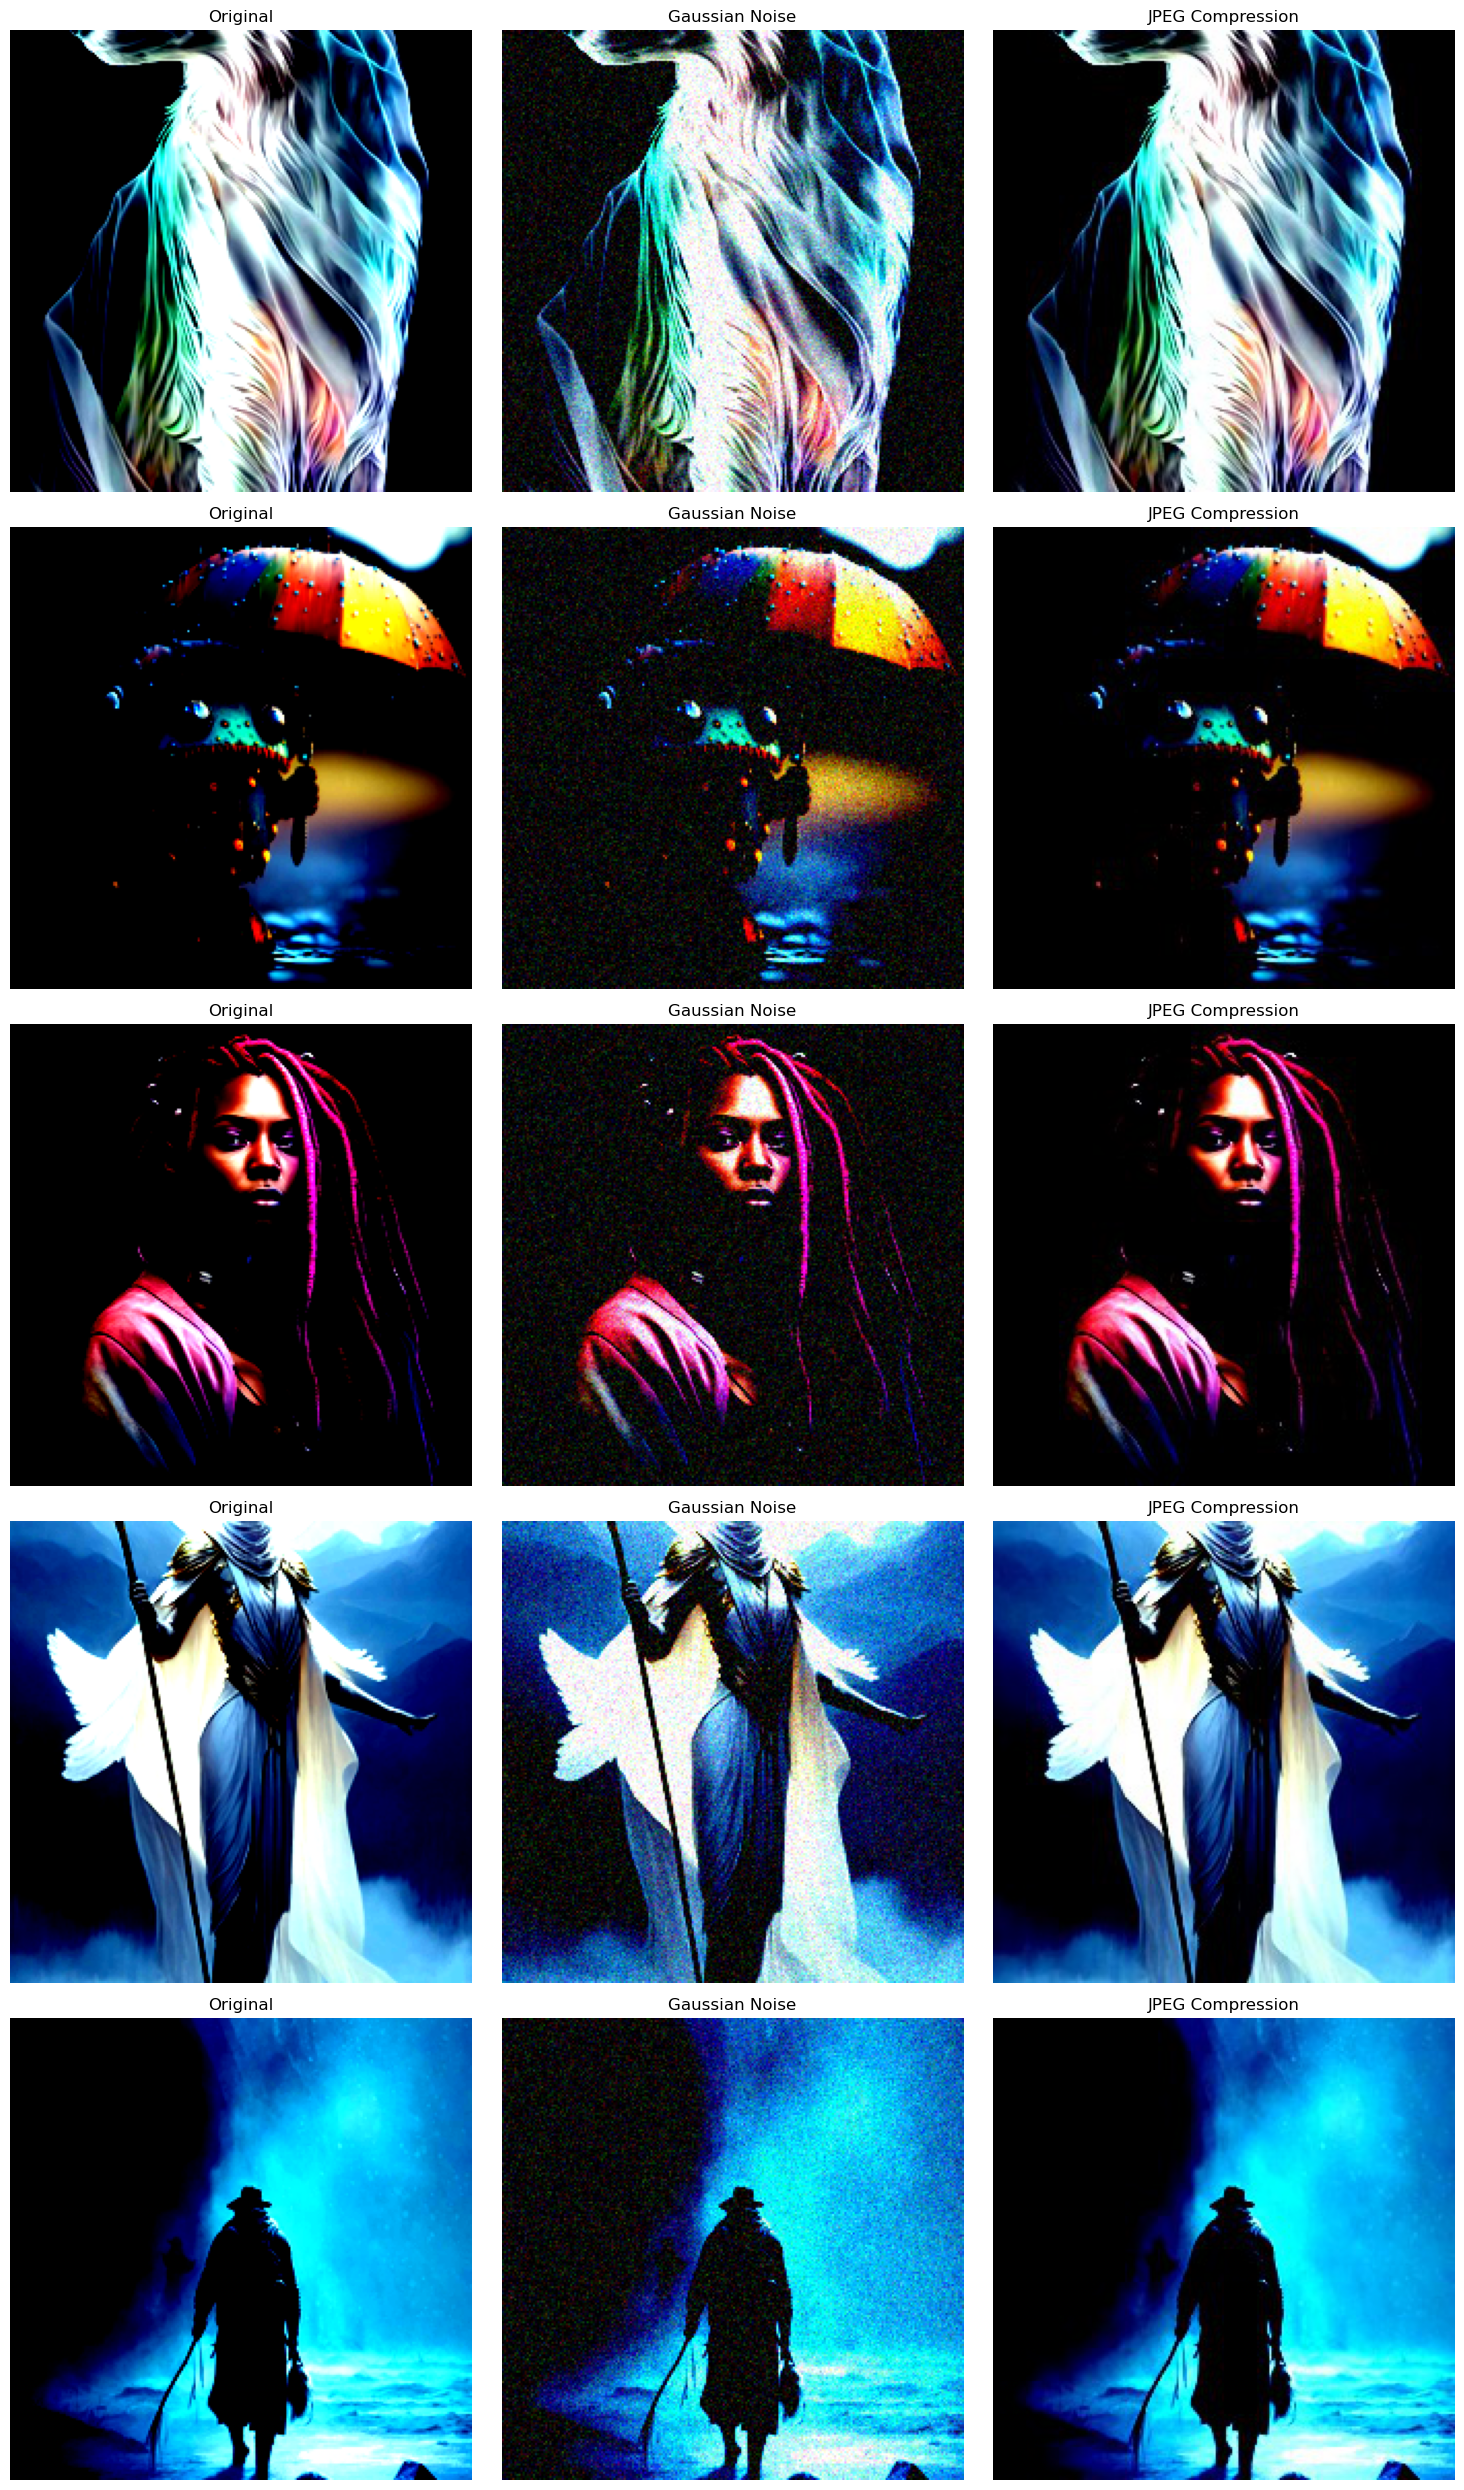

In [16]:
def visualize_samples(dataset, num_samples=5):
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5 * num_samples))
    
    for i in range(num_samples):
        original, _ = dataset[i]
        original = torch.clamp(original, 0, 1)
        
        noisy = add_gaussian_noise(original.unsqueeze(0)).squeeze(0)
        compressed = apply_jpeg_compression(original)
        
        original_pil = transforms.ToPILImage()(original.cpu())
        noisy_pil = transforms.ToPILImage()(torch.clamp(noisy, 0, 1).cpu())
        compressed_pil = transforms.ToPILImage()(torch.clamp(compressed, 0, 1).cpu())
        
        axes[i, 0].imshow(original_pil)
        axes[i, 0].set_title('Original')
        axes[i, 0].axis('off')
        
        axes[i, 1].imshow(noisy_pil)
        axes[i, 1].set_title('Gaussian Noise')
        axes[i, 1].axis('off')
        
        axes[i, 2].imshow(compressed_pil)
        axes[i, 2].set_title('JPEG Compression')
        axes[i, 2].axis('off')
    
    plt.tight_layout()
    plt.show()

visualize_samples(dataset, num_samples=5)